# (30) Fit -- cuda0

**Motivation**: Fitting notebook, cuda0 <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Trainer

In [2]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=9,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(
    model=vae,
    cfg=ConfigTrainVAE(
        lr=0.002, batch_size=500, epochs=2000, grad_clip=1000,
        lambda_anneal=True, lambda_init=1e-7, lambda_norm=1e-4, 
        kl_beta=0.25, kl_anneal_cycles=1, kl_anneal_portion=0.3, kl_const_portion=1e-4,
        scheduler_kws={'T_max': 650.0, 'eta_min': 1e-05},
    ),
    device='cuda:0',
)
vae.cfg.total_latents()

270

In [3]:
vae.print()
vae.scales

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.9 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.8 Mil   |
| dec_sampler  |  1.8 Mil   |
|    expand    |  117.2 K   |
|  dec_tower   |  4.6 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

[8, 4]

In [4]:
len(vae.all_conv_layers), len(vae.all_log_norm)

(291, 228)

## Review train options

In [5]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

k-32_z-9x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)
ep2000-b500-lr(0.002)_beta(0.25:1x0.3)_lamb(0.0001)_gr(1000)

## Train

In [6]:
comment = f"EPE-fixed_{tr.cfg.name()}"
tr.train(comment=comment)

epoch # 2000, avg loss: 2605.457764: 100%|██████████| 2000/2000 [32:56:49<00:00, 59.30s/it]                         


## Eval

In [7]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 33.7 s, sys: 20.2 s, total: 53.9 s
Wall time: 1min 29s


In [8]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(f"{vae.cfg.name()}\n{tr.cfg.name()}\n\n{loss_summary}\n")

k-32_z-9x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)
ep2000-b500-lr(0.002)_beta(0.25:1x0.3)_lamb(0.0001)_gr(1000)

{'epe': {'vae': 4.67, 'ema': 4.66}, 'kl': {'vae': 52.84, 'ema': 46.43}}

fig/sample (VAE)

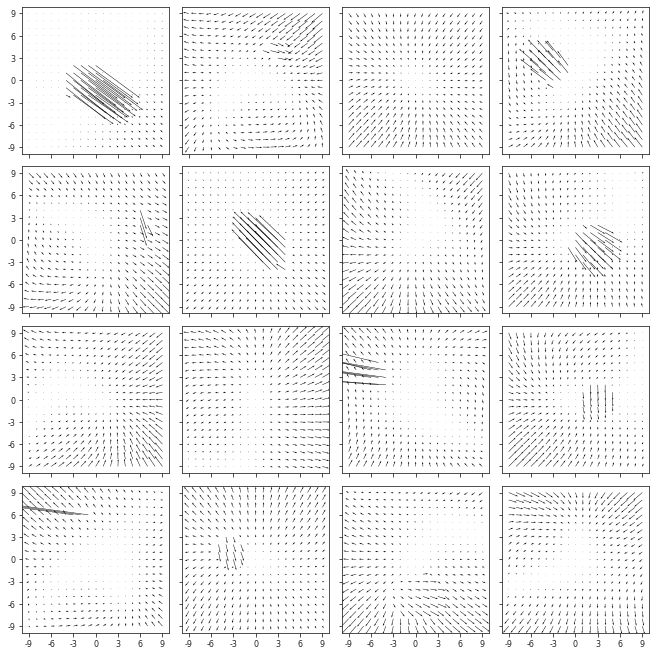

fig/sample (EMA)

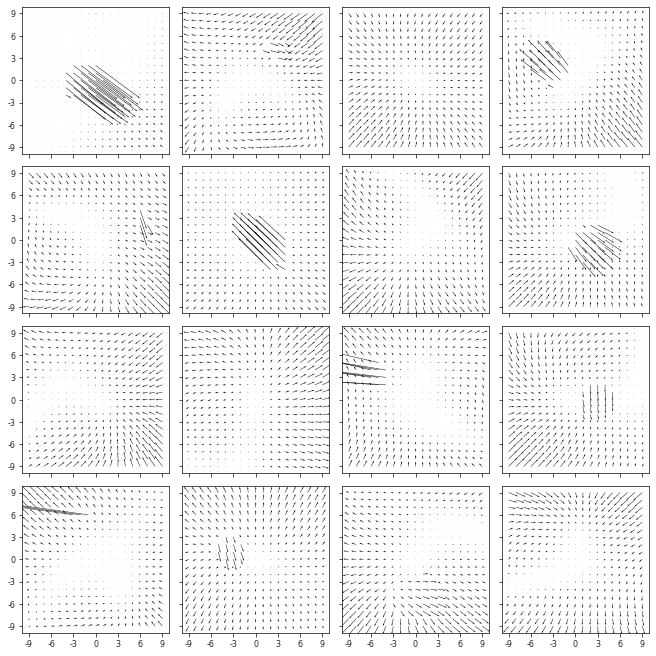

----------------------------------------------------------------------

fig/regression (VAE)

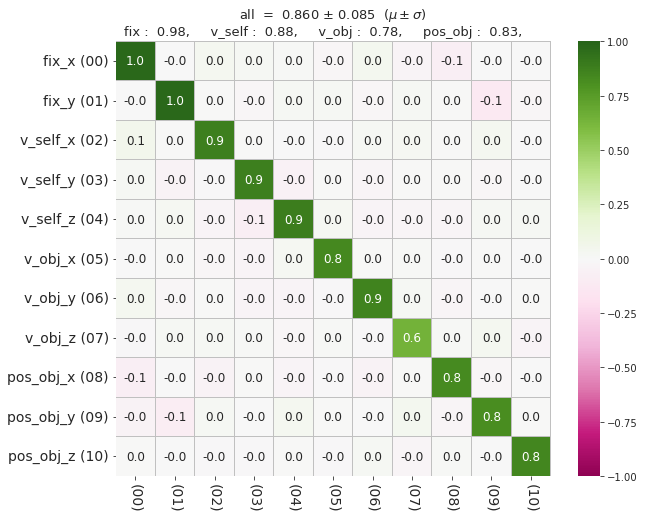

fig/regression (EMA)

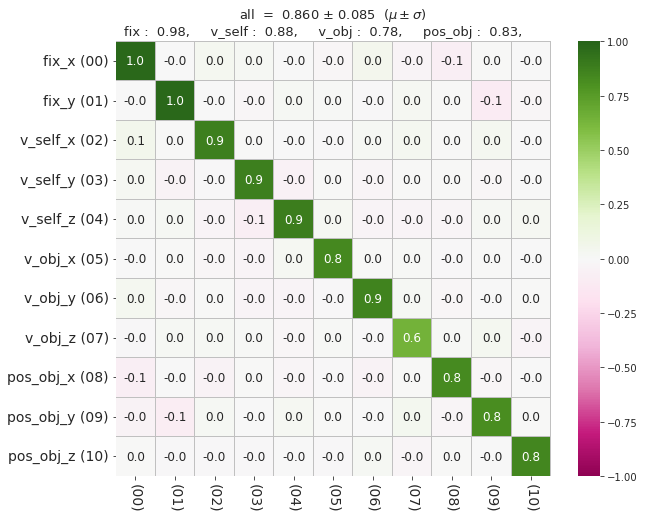

----------------------------------------------------------------------

fig/mutual_info (VAE)

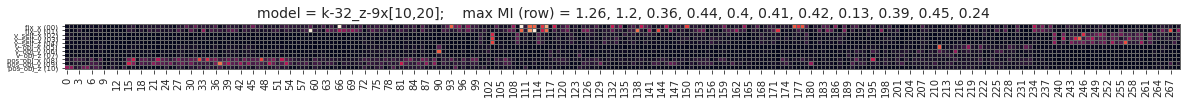

fig/mutual_info (EMA)

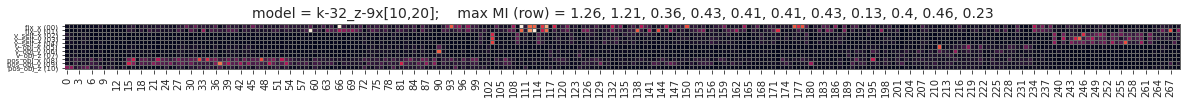

----------------------------------------------------------------------

In [9]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

In [14]:
val_ema['regr/r2'], val_ema['regr/r2'].mean(), np.diag(val_ema['regr/r']).mean()

(array([0.96127653, 0.95904093, 0.77579522, 0.77503227, 0.78862261,
        0.71017752, 0.7508213 , 0.4151603 , 0.69492847, 0.66162775,
        0.71374004]),
 0.7460202667082014,
 0.8597161003561453)

In [15]:
do_zscore = True
if do_zscore:
    x = sp_stats.zscore(val_ema['z_vld'])
    y = sp_stats.zscore(val_ema['g_vld'])
    x_tst = sp_stats.zscore(val_ema['z_tst'])
    y_tst = sp_stats.zscore(val_ema['g_tst'])
else:
    x = val_ema['z_vld']
    y = val_ema['g_vld']
    x_tst = val_ema['z_tst']
    y_tst = val_ema['g_tst']

lr = sk_linear.LinearRegression().fit(x, y)
r2_out = sk_metric.r2_score(
    y_true=y_tst,
    y_pred=lr.predict(x_tst),
    multioutput='raw_values',
)
r_out = 1 - sp_dist.cdist(
    XA=y_tst.T,
    XB=lr.predict(x_tst).T,
    metric='correlation',
)
r2_out, r2_out.mean(), np.diag(r_out).mean()

(array([0.96079889, 0.95901099, 0.75629839, 0.74387219, 0.76387143,
        0.69589639, 0.75146064, 0.40954115, 0.69268031, 0.66284467,
        0.70680033]),
 0.7366432160645678,
 0.8558008759316572)

In [16]:
z = val_ema['z_vld'].copy()
y = val_ema['g_vld'].copy()
z_tst = val_ema['z_tst'].copy()
y_tst = val_ema['g_tst'].copy()

mu, sd = z.mean(), z.std()
z = (z - mu) / sd
z_tst = (z_tst - mu) / sd

In [17]:
lr = sk_linear.LinearRegression().fit(z, y)
r2_out = sk_metric.r2_score(
    y_true=y_tst,
    y_pred=lr.predict(z_tst),
    multioutput='raw_values',
)
r_out = 1 - sp_dist.cdist(
    XA=y_tst.T,
    XB=lr.predict(z_tst).T,
    metric='correlation',
)
r2_out, r2_out.mean(), np.diag(r_out).mean()

(array([0.96127653, 0.95904093, 0.77579522, 0.77503227, 0.78862261,
        0.71017752, 0.7508213 , 0.4151603 , 0.69492847, 0.66162775,
        0.71374004]),
 0.7460202667082014,
 0.8597161003561453)

In [18]:
val_ema['regr/r2'].mean(), val_ema['regr/d'].mean(), val_ema['regr/c'].mean()

(0.7460202667082014, 0.22196501, 0.2130135)

In [21]:
from analysis.linear import compute_dci

In [22]:
w = np.abs(lr.coef_)
w *= x.std(0).reshape(1, -1)
w /= y.std(0).reshape(-1, 1)

compute_dci(w)

(0.13095993, 0.6471848)

In [23]:
z = val_ema['z_vld'].copy()
y = val_ema['g_vld'].copy()
z_tst = val_ema['z_tst'].copy()
y_tst = val_ema['g_tst'].copy()

mu, sd = z.mean(), z.std()
z = (z - mu) / sd
z_tst = (z_tst - mu) / sd

df = []
alphas = np.linspace(1e-5, 1e-2, 1000)
for a in tqdm(alphas):
    # fit
    lasso = sk_linear.Lasso(
        alpha=a,
        max_iter=1e5,
    ).fit(z, y)
    # eval: i
    r2_lasso = sk_metric.r2_score(
        y_true=y_tst,
        y_pred=lasso.predict(z_tst),
        multioutput='raw_values',
    )
    i = r2_lasso.mean()
    # eval: dc
    w = np.abs(lasso.coef_)
    w *= z.std(0).reshape(1, -1)
    w /= y.std(0).reshape(-1, 1)
    d, c = compute_dci(w)
    
    df.append({
        'alpha': [a],
        'd': [d],
        'c': [c],
        'i': [i],
        'avg': [(i + d) / 2],
    })
df = pd.DataFrame(merge_dicts(df))

  0%|          | 0/1000 [00:00<?, ?it/s]

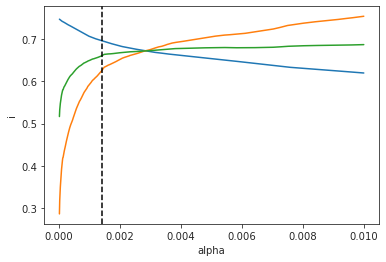

In [24]:
sns.lineplot(data=df, x='alpha', y='i')
sns.lineplot(data=df, x='alpha', y='d')
sns.lineplot(data=df, x='alpha', y='avg')
plt.axvline(0.0014, color='k', ls='--');

In [25]:
df['i'].max()

0.7464906705747453

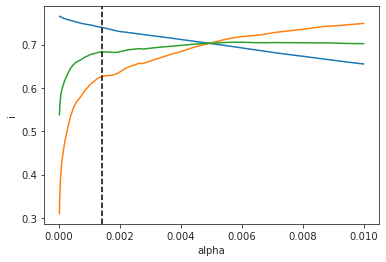

In [100]:
# previous fit

In [101]:
# df['i'].max()

0.7655837298942729

## DCI

In [111]:
from sklearn import linear_model as sk_linaer
from sklearn import metrics as sk_metric

In [112]:
lr = sk_linaer.LinearRegression().fit(
    sp_stats.zscore(val_ema['z_vld']), sp_stats.zscore(val_ema['g_vld']))
r2 = sk_metric.r2_score(
    y_true=sp_stats.zscore(val_ema['g_tst']),
    y_pred=lr.predict(sp_stats.zscore(val_ema['z_tst'])),
    multioutput='raw_values',
)
r2, r2.mean()

(array([0.47257855, 0.41006614, 0.71148849, 0.65121203, 0.67876901,
        0.61764076, 0.66847837, 0.46514175, 0.5267347 , 0.49140305,
        0.46601709]),
 0.5599572663966924)

In [113]:
w = np.abs(lr.coef_)
rho = w.sum(0) / w.sum()

In [114]:
p_disentang = w / w.sum(0, keepdims=True)
p_complete = w / w.sum(1, keepdims=True)
disentang_i = 1 - sp_stats.entropy(p_disentang, axis=0) / np.log(w.shape[0])
complete_mu = 1 - sp_stats.entropy(p_complete, axis=1) / np.log(w.shape[1])

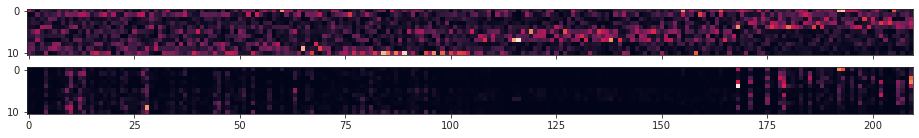

In [115]:
fig, axes = create_figure(2, 1, (13, 1.8), 'all', 'all', constrained_layout=True)
im = axes[0].imshow(p_disentang)
im = axes[1].imshow(p_complete)

In [116]:
disentang = (disentang_i * rho).sum()
compelte = complete_mu.mean()
disentang, compelte

(0.1707335, 0.20554298)

<AxesSubplot:ylabel='Count'>

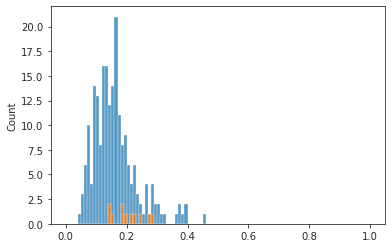

In [117]:
sns.histplot(disentang_i, bins=np.linspace(0, 1, 101), color='C0', label=r'$D_i$')
sns.histplot(complete_mu, bins=np.linspace(0, 1, 101), color='C1', label=r'$D_i$')

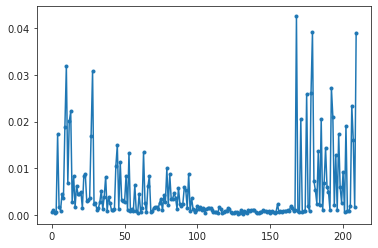

In [118]:
plt.plot(rho, marker='.')
plt.show()

In [161]:
lasso = sk_linaer.Lasso(alpha=0.01, max_iter=1e5).fit(
    sp_stats.zscore(val_ema['z_vld']), sp_stats.zscore(val_ema['g_vld']))
r2 = sk_metric.r2_score(
    y_true=sp_stats.zscore(val_ema['g_tst']),
    y_pred=lasso.predict(sp_stats.zscore(val_ema['z_tst'])),
    multioutput='raw_values',
)
r2, r2.mean()

(array([0.40400345, 0.38611246, 0.67665547, 0.61881159, 0.59310771,
        0.59439732, 0.64758267, 0.44776296, 0.50305118, 0.46551399,
        0.40510704]),
 0.5220096227631559)

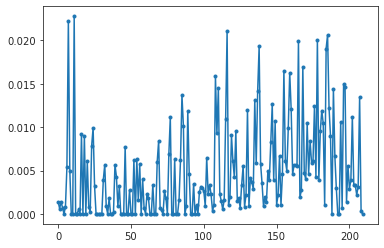

In [162]:
w = np.abs(lasso.coef_)
rho = w.sum(0) / w.sum()

plt.plot(rho, marker='.')
plt.show()

In [163]:
numen = w.sum(0, keepdims=True)
numen[numen == 0] = np.nan
p_disentang = w / numen

numen = w.sum(1, keepdims=True)
numen[numen == 0] = np.nan
p_complete = w / numen

disentang_i = 1 - sp_stats.entropy(p_disentang, axis=0) / np.log(w.shape[0])
complete_mu = 1 - sp_stats.entropy(p_complete, axis=1) / np.log(w.shape[1])

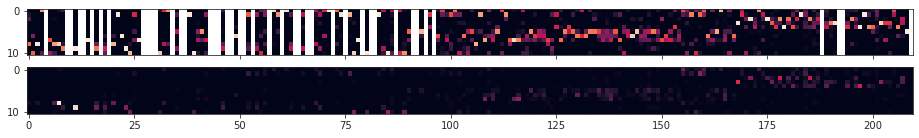

In [164]:
fig, axes = create_figure(2, 1, (13, 1.8), 'all', 'all', constrained_layout=True)
im = axes[0].imshow(p_disentang)
im = axes[1].imshow(p_complete)

In [165]:
disentang = np.nansum(disentang_i * rho)
compelte = np.nanmean(complete_mu)
disentang, compelte

(0.6517226, 0.41041154)

In [180]:
x = sp_stats.zscore(val_ema['z_vld'])
x_tst = sp_stats.zscore(val_ema['z_tst'])

which_g = 0
y = sp_stats.zscore(val_ema['g_vld'])[:, which_g]
y_tst = sp_stats.zscore(val_ema['g_tst'])[:, which_g]

lr = sk_linaer.LinearRegression().fit(x, y)
r2 = sk_metric.r2_score(
    y_true=y_tst,
    y_pred=lr.predict(x_tst),
    multioutput='raw_values',
)
r2, r2.mean()

(array([0.47257846]), 0.47257845940789023)

In [181]:
from sklearn import inspection as sk_inspect

In [207]:
importances = np.zeros((11, 210))
x = sp_stats.zscore(val_ema['z_vld'])
x_tst = sp_stats.zscore(val_ema['z_tst'])

for i in tqdm(range(11)):
    y = sp_stats.zscore(val_ema['g_vld'])[:, i]
    y_tst = sp_stats.zscore(val_ema['g_tst'])[:, i]

    lr = sk_linaer.LinearRegression().fit(x, y)
    result = sk_inspect.permutation_importance(
        lr, x, y, n_repeats=5, random_state=0)
    importances[i] = result.importances_mean

  0%|          | 0/11 [00:00<?, ?it/s]

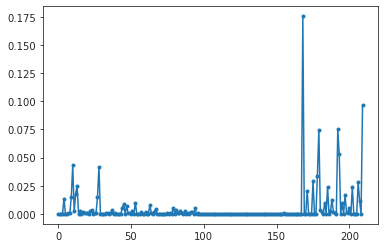

In [208]:
w = np.abs(importances)
rho = w.sum(0) / w.sum()
plt.plot(rho, marker='.')
plt.show()

In [209]:
numen = w.sum(0, keepdims=True)
numen[numen == 0] = np.nan
p_disentang = w / numen

numen = w.sum(1, keepdims=True)
numen[numen == 0] = np.nan
p_complete = w / numen

disentang_i = 1 - sp_stats.entropy(p_disentang, axis=0) / np.log(w.shape[0])
complete_mu = 1 - sp_stats.entropy(p_complete, axis=1) / np.log(w.shape[1])

In [210]:
disentang = np.nansum(disentang_i * rho)
compelte = np.nanmean(complete_mu)
disentang, compelte

(0.47556378862811566, 0.46334002992007495)

In [213]:
complete_mu

array([0.55834858, 0.4063492 , 0.5141145 , 0.5341176 , 0.5973893 ,
       0.37543179, 0.45205564, 0.36963424, 0.36606959, 0.5479916 ,
       0.37523828])

In [235]:
regr = regress(val['z_vld'], val['g_vld'], val['z_tst'], val['g_tst'])
regr_ema = regress(val_ema['z_vld'], val_ema['g_vld'], val_ema['z_tst'], val_ema['g_tst'])

In [230]:
list(regr_ema)

['mi', 'mi_norm', 'mig', 'r', 'r2', 'd', 'c']

In [236]:
regr['r2'].mean() * 100, regr_ema['r2'].mean() * 100

(57.10566690196461, 56.66935406464167)

In [237]:
np.diag(regr['r']).mean(), np.diag(regr_ema['r']).mean()

(0.7530953618826142, 0.7499362089110811)

In [246]:
ent = sp_stats.differential_entropy(val['g_vld'], method='vasicek', axis=0)
ent

array([ 0.48521482,  0.49381382,  0.27086478,  0.27571696,  0.27490406,
        0.96252636,  0.96879261,  0.96706354,  0.43790779,  0.4336104 ,
       -0.703086  ])

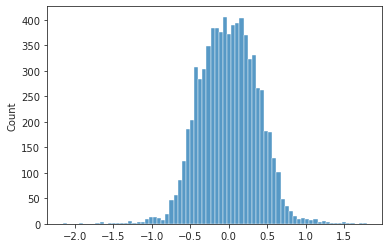

In [282]:
sns.histplot(val['g_vld'][:, 9]);

In [284]:
tr.dl_tst.dataset.factor_names

{0: 'fix_x',
 1: 'fix_y',
 2: 'v_self_x',
 3: 'v_self_y',
 4: 'v_self_z',
 5: 'v_obj_x',
 6: 'v_obj_y',
 7: 'v_obj_z',
 8: 'pos_obj_x',
 9: 'pos_obj_y',
 10: 'pos_obj_z'}

In [280]:
entropy_discrete(val['g_vld'][:, 9], 20)

0.6872872163742719

In [285]:
1 - 1e-3

0.999

## Gradient quantiles

In [12]:
a = np.stack(tr.stats['q'])
a.shape

(3028, 4)

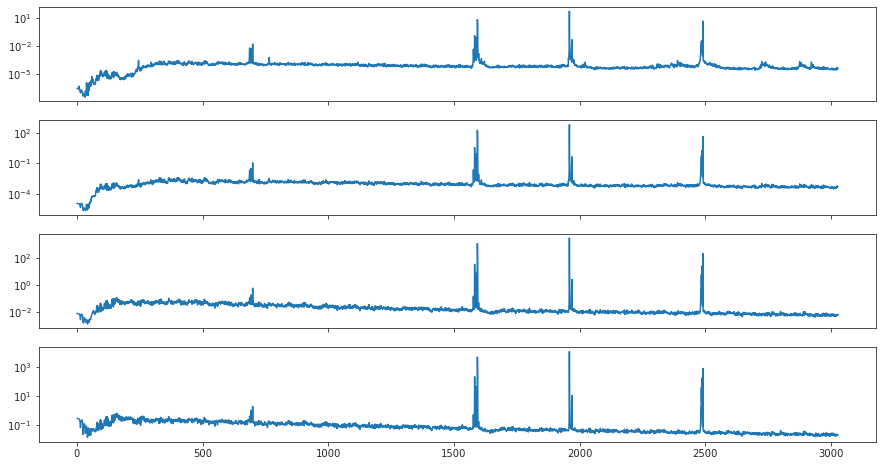

In [21]:
fig, axes = create_figure(4, 1, (15, 8), 'all')
for i, ax in enumerate(axes.flat):
    ax.plot(a[:, i])
    ax.set_yscale('log')

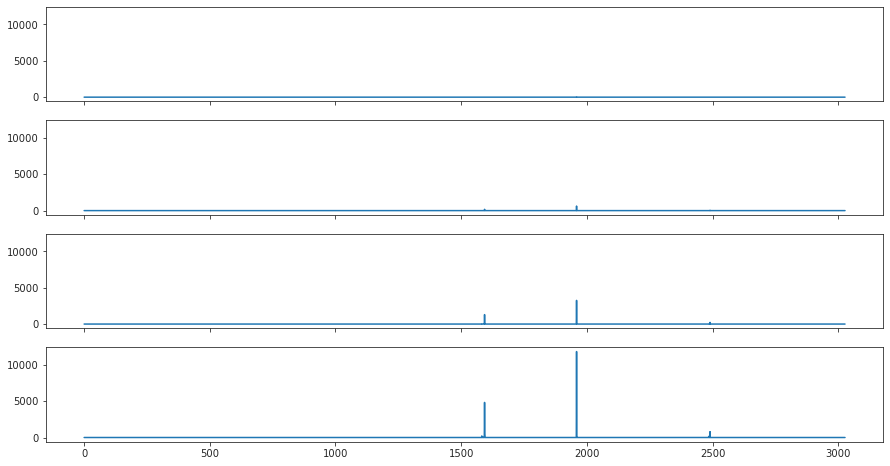

In [23]:
fig, axes = create_figure(4, 1, (15, 8), 'all', 'all')
for i, ax in enumerate(axes.flat):
    ax.plot(a[:, i])
    # ax.set_yscale('log')

In [27]:
ids = np.argsort(a[:, 3])[::-1]

In [29]:
a[ids][:10]

array([[4.70497303e+01, 6.24381454e+02, 3.25176420e+03, 1.18062537e+04],
       [6.09734440e+00, 1.76353558e+02, 1.29898698e+03, 4.81890981e+03],
       [4.28144193e+00, 4.32554083e+01, 2.24989483e+02, 8.07263673e+02],
       [2.16084993e+00, 1.57247159e+01, 9.92054600e+01, 4.63432818e+02],
       [1.19143877e-01, 3.40490681e+00, 3.50532925e+01, 2.12924517e+02],
       [3.73780169e-02, 1.79290777e+00, 2.68807427e+01, 1.75726674e+02],
       [7.94552900e-02, 8.66108224e-01, 7.59450638e+00, 4.32092611e+01],
       [2.84448471e-02, 5.04085064e-01, 5.93678675e+00, 3.94013906e+01],
       [3.92370038e-02, 2.42084436e-01, 1.97695330e+00, 1.15657066e+01],
       [4.41845823e-02, 4.34113048e-01, 2.57850293e+00, 1.09694010e+01]])

## Eval fit (old code)

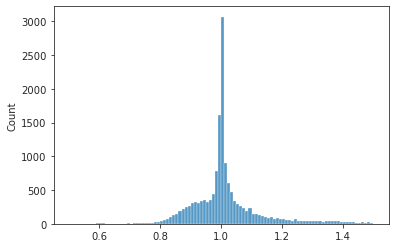

In [12]:
all_norm = [torch.exp(n.ravel()) for n in vae.all_log_norm]
all_norm = to_np(torch.cat(all_norm))
sns.histplot(all_norm, bins=np.linspace(0.5, 1.5, 101));

In [13]:
np.max(all_norm), 100 * (all_norm < 0.5).sum() / len(all_norm), 100 * (all_norm > 1.5).sum() / len(all_norm)

(5.9622617, 0.018766420618040784, 3.0401601401226075)

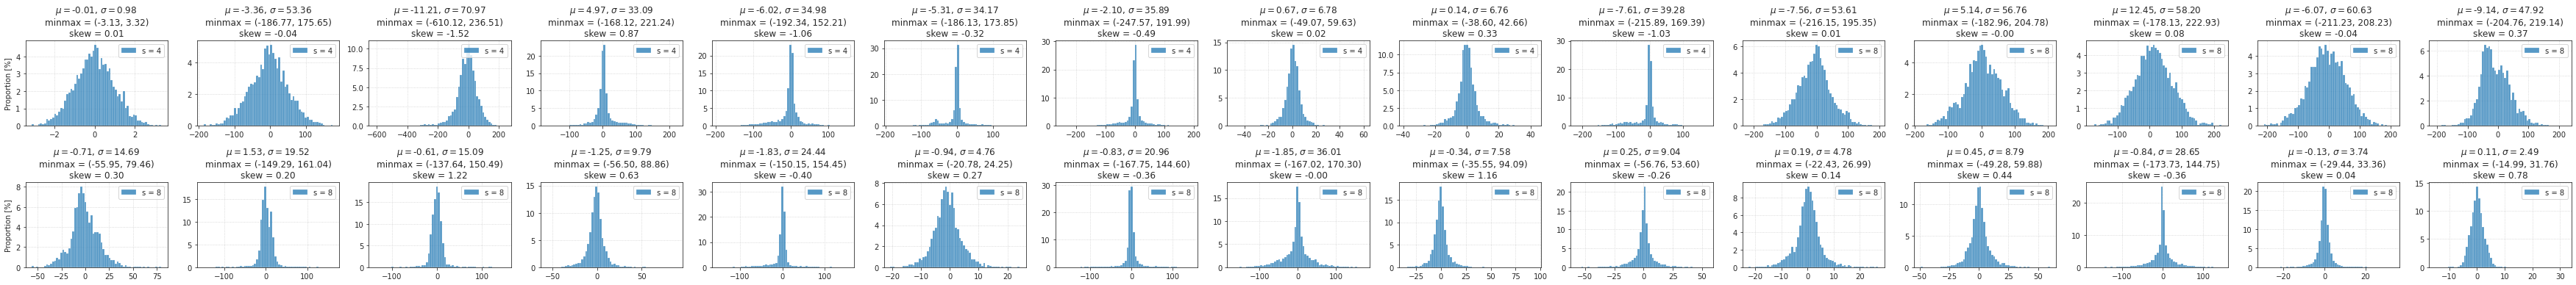

In [14]:
_ = plot_latents_hist(
    z=val['z_sample'],
    scales=vae.latent_scales()[0],
)

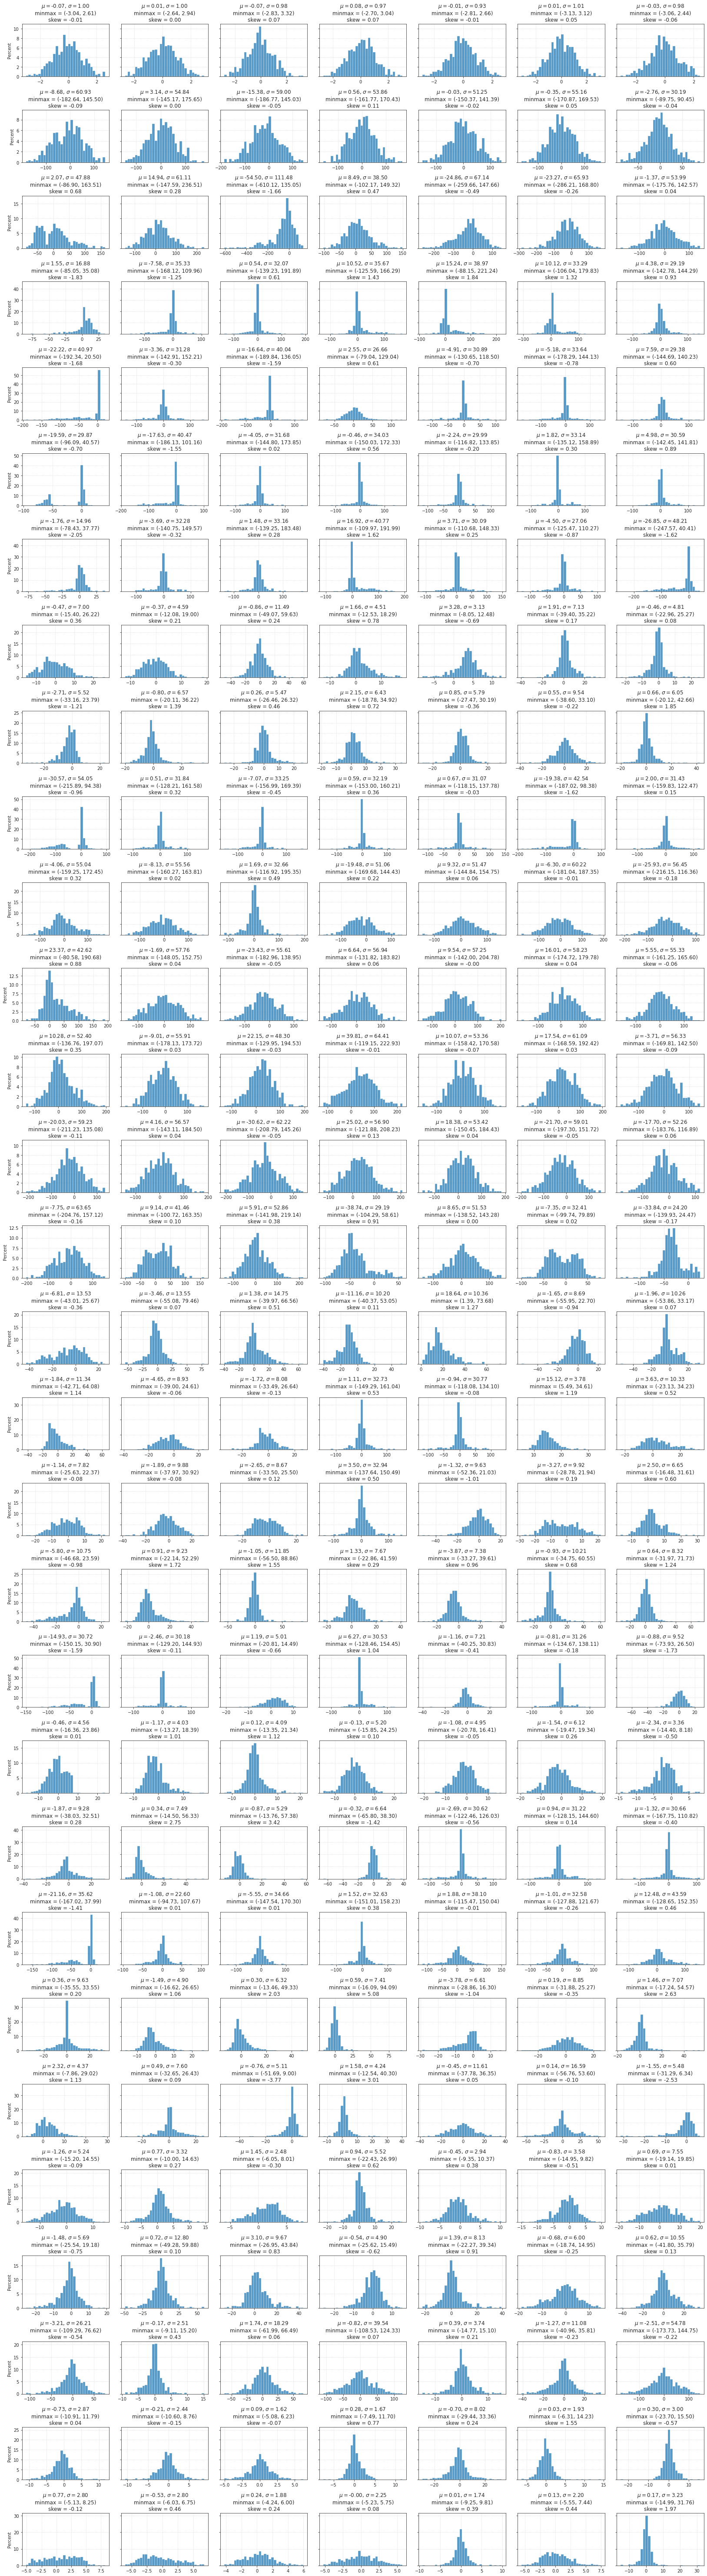

CPU times: user 39.4 s, sys: 1.17 s, total: 40.6 s
Wall time: 40.6 s


In [15]:
%%time

_ = plot_latents_hist_full(
    z=val['z_sample'],
    scales=vae.latent_scales()[0],
    constrained_layout=False,
    tight_layout=True,
)

In [35]:
names = tr.dl_tst.dataset.factor_names
_tx = [f"({i:02d})" for i in range(len(names))]
_ty = [f"{e} ({i:02d})" for i, e in names.items()]

In [62]:
title = '_'.join(tr.model.cfg.name().split('_')[:2])
mi_max = np.round(np.max(val['regr/mi'], axis=1), 2)
mi_max = ', '.join([str(e) for e in mi_max])
title = f"model = {title};    max MI (row) = {mi_max}"

fig, _ = show_heatmap(
    r=val['regr/mi'],
    yticklabels=_ty,
    title=title,
    tick_labelsize_x=10,
    tick_labelsize_y=7,
    title_fontsize=14,
    title_y=1.02,
    vmin=0,
    vmax=0.65,
    cmap='rocket',
    linecolor='dimgrey',
    cbar=False,
    figsize=(20, 5),
    annot=False,
    display=False,
)

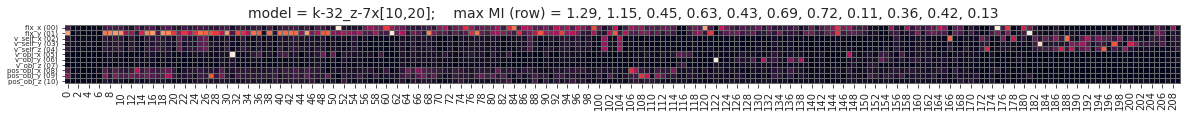

In [63]:
fig

In [64]:
from model.vae2d import *

In [66]:
norms = collections.defaultdict(list)
# norms['stem'] = list(to_np(vae.stem.lognorm.exp()))
for cell in vae.enc_tower:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_enc"].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.dec_tower:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_dec"].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.enc_sampler:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['enc_sampler'].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.dec_sampler:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['dec_sampler'].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.expand:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['expand'].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.pre_process:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_pre"].extend(
                list(to_np(m.lognorm.exp())))
for cell in vae.post_process:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_post"].extend(
                list(to_np(m.lognorm.exp())))
norms = dict(sorted(norms.items()))

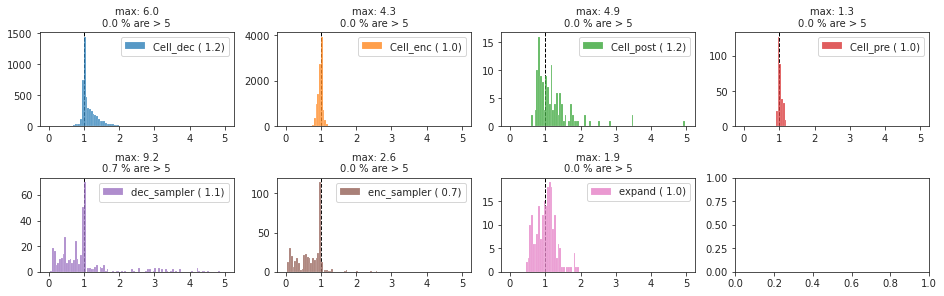

In [67]:
fig, axes = create_figure(2, 4, (13, 4), constrained_layout=True)
for i, (k, v) in enumerate(norms.items()):
    ax = axes.flat[i]
    ax.axvline(1, color='k', ls='--', lw=1.0, zorder=0)
    sns.histplot(v, color=f"C{i}", bins=np.linspace(0, 5, 101), label=f"{k} ({np.mean(v): 0.1f})", ax=ax)
    title = f"max: {np.max(v):0.1f}\n{100 * (np.array(v) > 5).sum() / len(v):0.1f} % are > 5"
    ax.set_title(title, fontsize=10)
    ax.set_ylabel('')
    ax.legend()
plt.show()

In [72]:
x, norm = next(iter(tr.dl_tst))
y, z, q, p = tr.model(x)

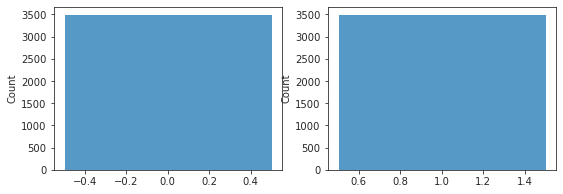

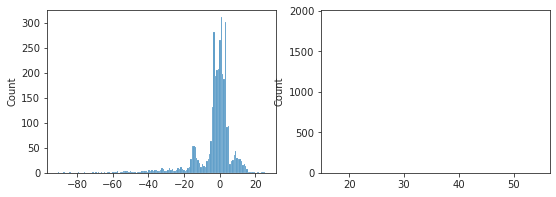

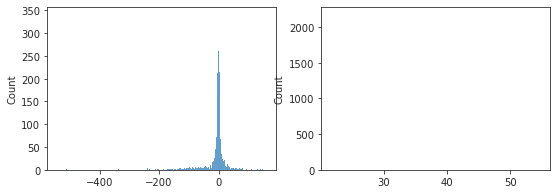

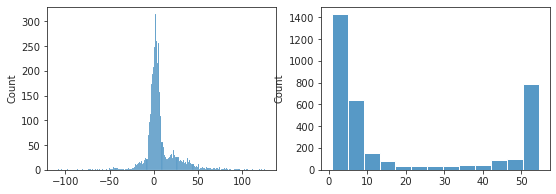

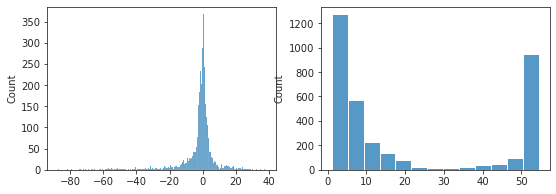

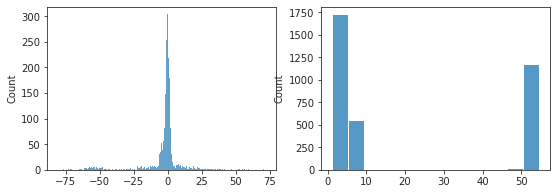

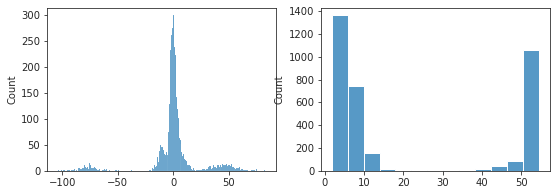

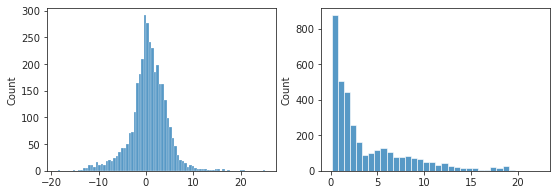

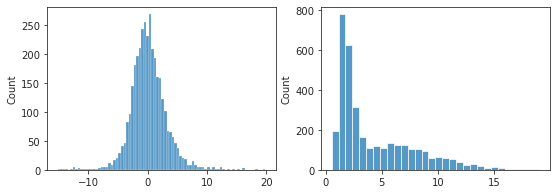

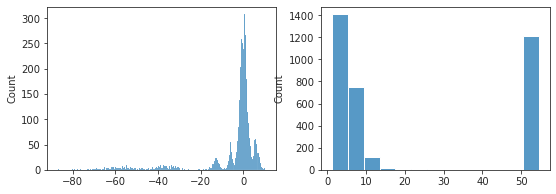

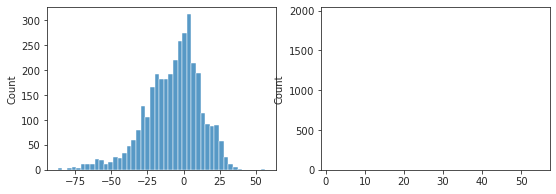

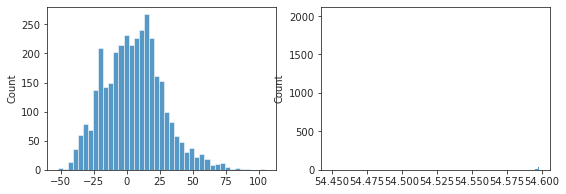

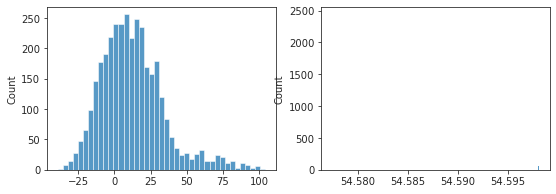

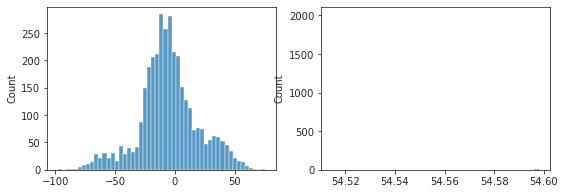

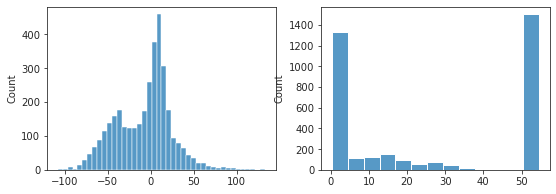

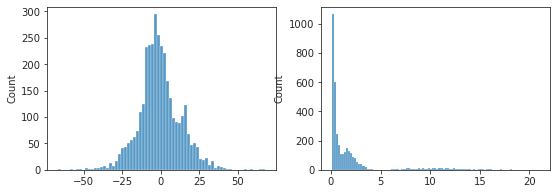

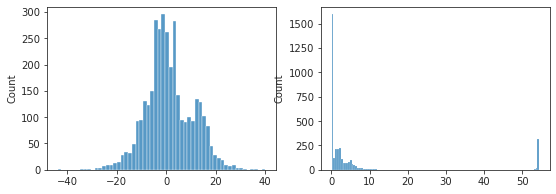

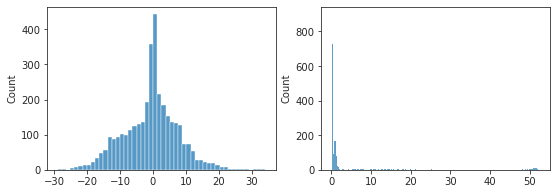

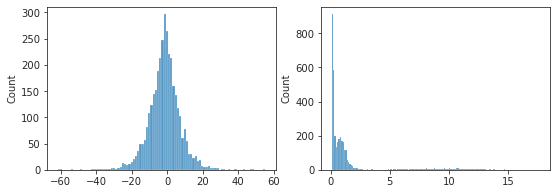

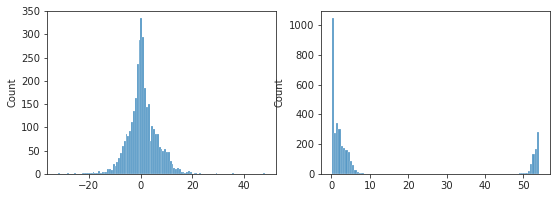

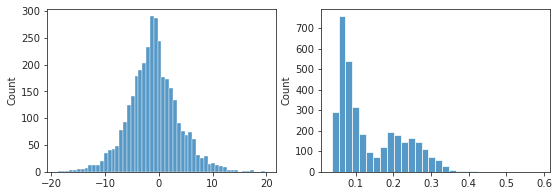

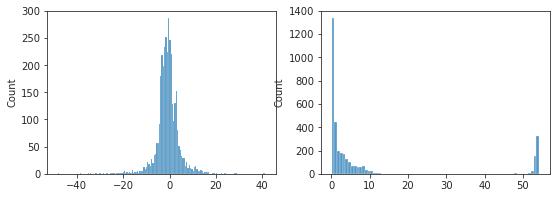

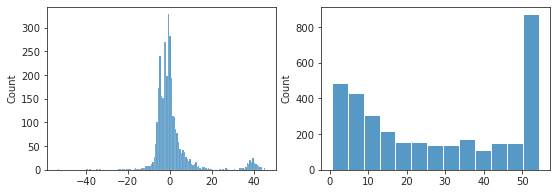

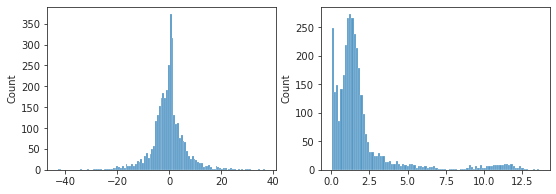

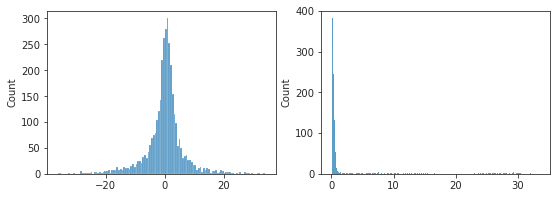

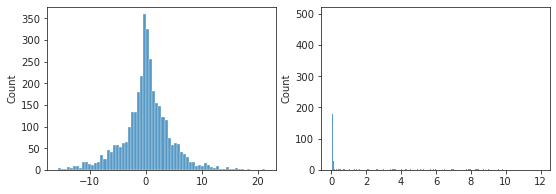

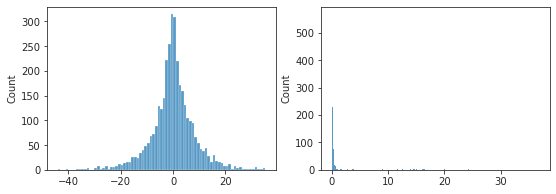

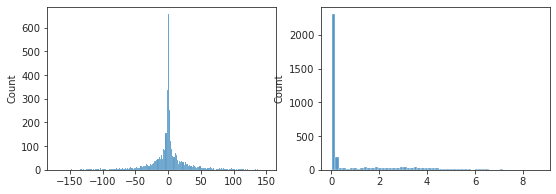

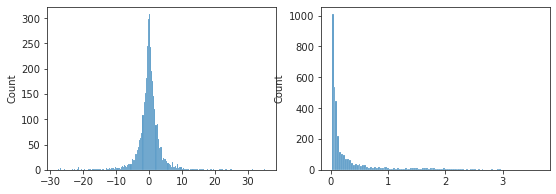

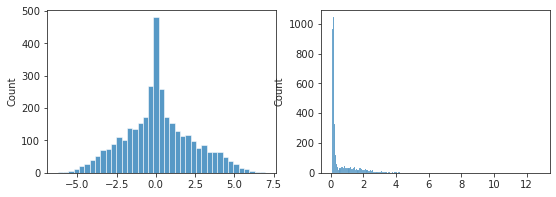

In [84]:
for dist in p:
    fig, axes = create_figure(1, 2, (9, 3))
    sns.histplot(to_np(dist.mu.squeeze().ravel()), ax=axes[0])
    sns.histplot(to_np(dist.sigma.squeeze().ravel()), ax=axes[1])
    plt.show()